In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba_stats import truncnorm, truncexpon
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL, UnbinnedNLL

## no shape variation just yield
mrange = (5000,5600)
ns = 1000
nb = 1000
mu = 5280
sg = 30
lb = 200

def generate(poisson=True):
    
    nsig = np.random.poisson(ns) if poisson else ns
    nbkg = np.random.poisson(nb) if poisson else nb
    
    scat = np.ones(nsig).astype(np.int32)
    bcat = np.zeros(nbkg).astype(np.int32)
    
    # generate
    sm_vals = truncnorm.ppf(np.random.uniform(size=nsig),*mrange,mu,sg)
    bm_vals = truncexpon.ppf(np.random.uniform(size=nbkg),*mrange,mrange[0],lb)
    
    # join
    cat = np.concatenate((scat,bcat))
    mass = np.concatenate((sm_vals,bm_vals))
        
    df = pd.DataFrame(columns=['mass','cat'])
    df['mass'] = mass
    df['cat']  = cat
    
    return df

def mass_pdf(x, nsig, nbkg, mu, sg, lb, comps=['sig','bkg']):
    
    tot = 0
    if 'sig' in comps:
        tot += nsig * truncnorm.pdf(x,*mrange,mu,sg)
    if 'bkg' in comps:
        tot += nbkg * truncexpon.pdf(x,*mrange,mrange[0],lb)
    return tot
        
def cost_density(x, nsig, nbkg, mu, sg, lb):
    
    return nsig+nbkg, mass_pdf(x, nsig, nbkg, mu, sg, lb)

def fit_toy(data, quiet=False, fix_shape=False):
    
    nll = ExtendedUnbinnedNLL(data,cost_density)
    mi  = Minuit(nll,nsig=ns,nbkg=nb,mu=mu,sg=sg,lb=lb)
    mi.limits['nsig','nbkg'] = (0,2*(ns+nb))
    mi.limits['mu'] = mrange
    mi.limits['sg'] = (0,100)
    mi.limits['lb'] = (1,1000)
    if fix_shape:
        mi.fixed['mu','sg','lb'] = True
    mi.migrad()
    mi.hesse()
    if not quiet: print(mi.params)
    return mi

def plot_toy(toy, mi=None, nbins=50):

    fig, ax = plt.subplots()
    
    if mi is None:
    
        ax.hist((bmvals, smvals),label=['Bkg','Sig'],stacked=True,bins=nbins) 
        
    else:
        
        mnh, mxe = np.histogram(toy,bins=nbins,range=mrange)
        mcx = 0.5*(mxe[1:]+mxe[:-1])
        
        ax.errorbar( mcx, mnh, mnh**0.5, fmt='ko', label='Toy')
        
        x = np.linspace(*mrange, 400)
        N = np.diff(mrange)/nbins
          
        sy = N*mass_pdf(x,**mi.values.to_dict(), comps=['sig'])
        by = N*mass_pdf(x,**mi.values.to_dict(), comps=['bkg'])
        ty = N*mass_pdf(x,**mi.values.to_dict())
        
        
        ax.plot(x,by,'r--',label='Background')
        ax.plot(x,sy,'g:', label='Signal')
        ax.plot(x,ty, 'b-', label='Total')



    
    ax.set_xlabel('Mass')
    
    ax.legend()
    



┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig │  1.06e3   │  0.04e3   │            │            │    0    │  4000   │       │
│ 1 │ nbkg │    920    │    40     │            │            │    0    │  4000   │       │
│ 2 │ mu   │ 5.2798e3  │ 0.0012e3  │            │            │  5000   │  5600   │       │
│ 3 │ sg   │   32.3    │    1.1    │            │            │    0    │   100   │       │
│ 4 │ lb   │    202    │    10     │            │            │    1    │  1000   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
1053
928


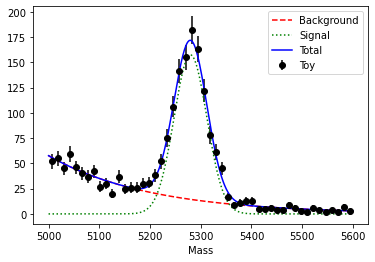

In [79]:
toy = generate()
mass = toy['mass'].to_numpy()
mi = fit_toy(mass)
plot_toy(mass,mi)

#print(toy)
print(len(toy[toy['cat']==1]))
print(len(toy[toy['cat']==0]))


In [87]:
from tqdm import tqdm

ntoys = 10000

df = pd.DataFrame(columns=['nsig','nbkg','e_nsig','e_nbkg','nsgen','nbgen'])

for i in tqdm(range(ntoys),desc='Generating'):
    toy = generate()
    mass = toy['mass'].to_numpy()
    mi = fit_toy(mass, quiet=True)
    
    df = df.append( { 'nsig': mi.values['nsig'],
                      'e_nsig' : mi.errors['nsig'],
                      'nbkg': mi.values['nbkg'],
                      'e_nbkg' : mi.errors['nbkg'],
                      'mu': mi.values['mu'],
                      'e_mu' : mi.errors['mu'],
                      'sg': mi.values['sg'],
                      'e_sg' : mi.errors['sg'],
                      'lb': mi.values['lb'],
                      'e_lb' : mi.errors['lb'],
                      'nsgen': len( toy[toy['cat']==1] ),
                      'nbgen': len( toy[toy['cat']==0] )
                    }, ignore_index=True)

print(df)

Generating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:09<00:00, 32.28it/s]

             nsig         nbkg     e_nsig     e_nbkg   nsgen   nbgen  \
0      955.866916  1042.149947  36.213377  37.385690   959.0  1039.0   
1      964.426082  1032.625651  36.108594  37.040139   989.0  1008.0   
2     1006.129765  1007.935321  37.104996  37.129463  1014.0  1000.0   
3     1036.590678   973.340706  37.643014  36.792606  1005.0  1005.0   
4      956.124111  1010.882950  36.236351  36.984262   967.0  1000.0   
...           ...          ...        ...        ...     ...     ...   
9995   989.279489  1073.762978  36.724774  37.857015  1018.0  1045.0   
9996  1011.159931   964.669494  37.103423  36.472915   965.0  1011.0   
9997   948.496179   959.496470  36.285035  36.436486   969.0   939.0   
9998  1044.594276   972.411511  37.012619  36.024599  1042.0   975.0   
9999   937.516638   968.433585  35.702508  36.132997   920.0   986.0   

           e_lb      e_mu      e_sg          lb           mu         sg  
0     10.356626  1.178733  1.003224  211.038297  5278.714206 

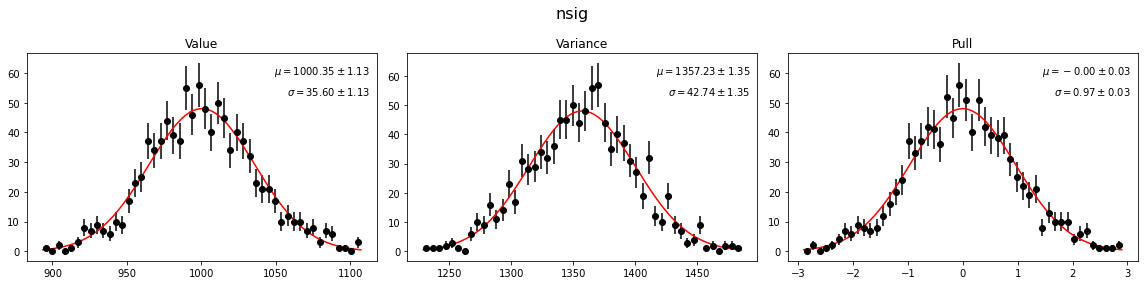

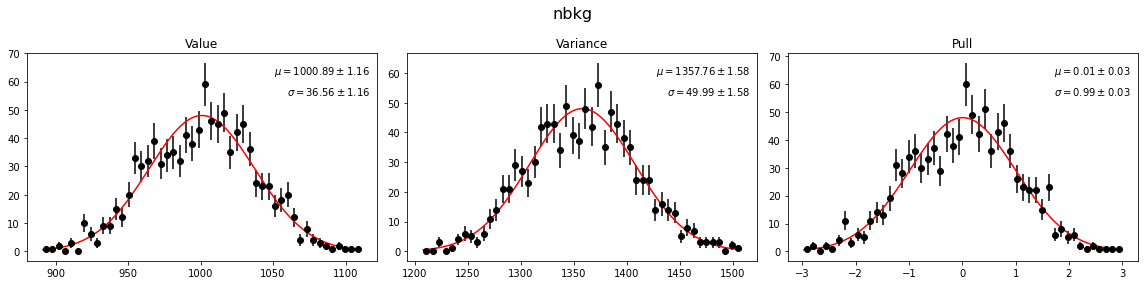

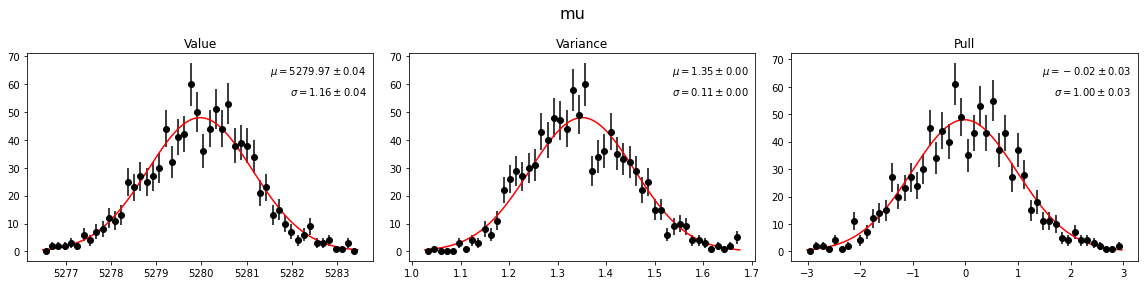

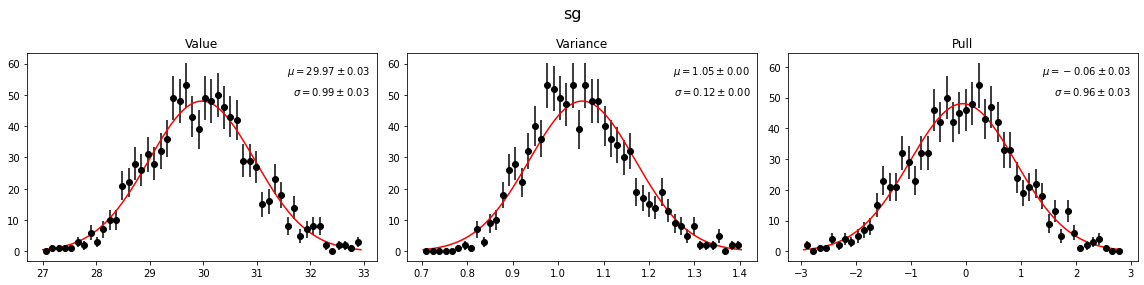

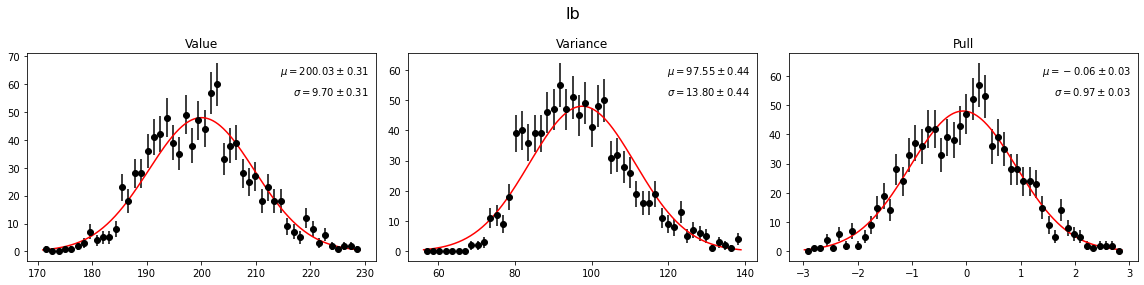

In [86]:
def stats(vals, errs, truth, fvals=False, title=None):
    fig, ax = plt.subplots(1,3,figsize=(16,4))
    
    pulls = (vals-truth)/errs
    varis = errs**2
    
    for i, (name, val) in enumerate(zip( ['Value','Variance','Pull'], [vals,varis,pulls] )):
        mean = np.mean(val)
        sdev = np.std(val,ddof=1)
        ermean = sdev / len(val)**0.5
        ersdev = sdev / (len(val)-1)**0.5
        
        #nh, xe, _ = ax[i].hist(val, bins=50)
        nh, xe = np.histogram(val, bins=50, range=(mean-3*sdev,mean+3*sdev))
        cx = 0.5*(xe[:-1]+xe[1:])
        
        
        
        if fvals:
            density = lambda x, mu,sg: truncnorm.pdf(x,xe[0],xe[-1],mu,sg)
            cst = UnbinnedNLL(val, density)
            mi  = Minuit(cst, mu=mean, sg=sdev)
            mi.migrad()
            mi.hesse()
            mean = mi.values['mu']
            sdev = mi.values['sg']
            ermean = mi.errors['mu']
            ersdev = mi.errors['sg']
       
        
        ax[i].errorbar(cx, nh, nh**0.5, fmt='ko')
        ax[i].set_title(name)
        
        ax[i].text(0.98,0.9,f'$\mu={mean:4.2f}\pm{ermean:4.2f}$', transform=ax[i].transAxes, ha='right')
        ax[i].text(0.98,0.8,f'$\sigma={sdev:4.2f}\pm{ersdev:4.2f}$', transform=ax[i].transAxes, ha='right')
        
        x = np.linspace(xe[0],xe[-1],400)
        y = len(val)*(xe[1]-xe[0])*truncnorm.pdf(x,xe[0],xe[-1],mean,sdev)
        ax[i].plot(x, y,'r-')
        
    if title:
        fig.suptitle(title, fontsize=16)
        
    fig.tight_layout()
        
for var, truth in zip(['nsig','nbkg','mu','sg','lb'],[ns,nb,mu,sg,lb]):
    stats( df[var], df[f'e_{var}'], truth, title=var )
